# Distribution dans le temps de batailles renseignées dans Wikidata

On utilise les données de Wikidata pour étudier la distribution dans le temps de variables quantitatives

In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pprint
import csv
import ast
import sys


from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

import re

In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
#sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [5]:
query = """
SELECT DISTINCT ?item ?itemLabel ?coordinates ?battle_date ?start_time ?end_time
    WHERE {
        {
          {?item wdt:P31 wd:Q178561.
                 OPTIONAL {?item wdt:P625 ?coordinates.
                          ?item wdt:P585 ?battle_date}
                 OPTIONAL {?item wdt:P580 ?start_time;
                            wdt:P582 ?end_time}         
      FILTER(bound(?battle_date))

      # BIND(xsd:integer(REPLACE(str(?battle_date), "(.*)([0-9]{4})(.*)", "$2")) AS ?battle_year)
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        }  
      }
    }  
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

<class 'dict'>
6436


[['http://www.wikidata.org/entity/Q219230',
  'Marco Polo Bridge incident',
  'Point(116.213056 39.849167)',
  '1937-07-09T00:00:00Z',
  '1937-07-07T00:00:00Z',
  '1937-07-09T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q244980',
  'Siege of Belgrade',
  'Point(20.466666666 44.816666666)',
  '1456-01-01T00:00:00Z',
  '1456-07-13T00:00:00Z',
  '1456-07-31T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q221891',
  'Second Battle of Artois',
  'Point(2.75 50.5)',
  '1915-06-18T00:00:00Z',
  '1915-05-09T00:00:00Z',
  '1915-06-18T00:00:00Z']]

In [7]:
### Créer un DataFrame à partir du résultat
df_b = pd.DataFrame(r)
df_b.columns = ['uri', 'label', 'geo_coordinates', 'battle_date', 'start_time', 'end_time']
df_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time
0,http://www.wikidata.org/entity/Q219230,Marco Polo Bridge incident,Point(116.213056 39.849167),1937-07-09T00:00:00Z,1937-07-07T00:00:00Z,1937-07-09T00:00:00Z
1,http://www.wikidata.org/entity/Q244980,Siege of Belgrade,Point(20.466666666 44.816666666),1456-01-01T00:00:00Z,1456-07-13T00:00:00Z,1456-07-31T00:00:00Z
2,http://www.wikidata.org/entity/Q221891,Second Battle of Artois,Point(2.75 50.5),1915-06-18T00:00:00Z,1915-05-09T00:00:00Z,1915-06-18T00:00:00Z
3,http://www.wikidata.org/entity/Q154182,Battle of Berlin,Point(13.376111111 52.518611111),1945-05-02T00:00:00Z,1945-04-16T00:00:00Z,1945-05-02T00:00:00Z
4,http://www.wikidata.org/entity/Q371620,First Battle of Benghazi,Point(20.066666666 32.116666666),2011-02-20T00:00:00Z,2011-02-15T00:00:00Z,2011-02-20T00:00:00Z


In [14]:
### Structure du DataFrame résultat
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6436 entries, 0 to 6435
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uri              6436 non-null   object 
 1   label            6436 non-null   object 
 2   geo_coordinates  6436 non-null   object 
 3   battle_date      6436 non-null   object 
 4   start_time       6436 non-null   object 
 5   end_time         6436 non-null   object 
 6   year             2 non-null      float64
dtypes: float64(1), object(6)
memory usage: 352.1+ KB


In [15]:
### Définir une fonction qui transformer l'année en entier
# avec signe positif si après J.C. ou négatif si avant J.C.
def f1(a):
    if a[0] == '-':
        r = int(a[:5])
    else:
        r = int(a[:4])
    return r     

In [16]:
### Tester la fonction 
# On peut changer les valeurs et observer le résultat
f1('-0390-01')

-390

In [17]:
### isoler le premier caractère de la date
bd = df_b.iloc[0]['battle_date']
print(bd, '-> ', bd[0])

1937-07-09T00:00:00Z ->  1


### Préparer à partir d'un exemple

In [18]:
df_b['year'] = df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)].apply(lambda x: f1(x['battle_date']), axis=1)

In [19]:
df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
1690,http://www.wikidata.org/entity/Q391087,Battle of Cynoscephalae,Point(22.5667 39.4167),-0196-01-01T00:00:00Z,,,-196.0
3269,http://www.wikidata.org/entity/Q2334746,Battle of Cynoscephalae,Point(22.83 39.36),-0363-01-01T00:00:00Z,,,-363.0


### Transformer tout le tableau

In [20]:
df_b['year'] = df_b.apply(lambda x: f1(x['battle_date']), axis=1)

In [21]:
df_b[:3]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
0,http://www.wikidata.org/entity/Q219230,Marco Polo Bridge incident,Point(116.213056 39.849167),1937-07-09T00:00:00Z,1937-07-07T00:00:00Z,1937-07-09T00:00:00Z,1937
1,http://www.wikidata.org/entity/Q244980,Siege of Belgrade,Point(20.466666666 44.816666666),1456-01-01T00:00:00Z,1456-07-13T00:00:00Z,1456-07-31T00:00:00Z,1456
2,http://www.wikidata.org/entity/Q221891,Second Battle of Artois,Point(2.75 50.5),1915-06-18T00:00:00Z,1915-05-09T00:00:00Z,1915-06-18T00:00:00Z,1915


## Détecter les doublons

In [32]:
gb_uri = df_b.groupby('uri').size()
gb_uri.loc[lambda x : x > 1]

uri
http://www.wikidata.org/entity/Q1018969      2
http://www.wikidata.org/entity/Q1028296      2
http://www.wikidata.org/entity/Q104541845    2
http://www.wikidata.org/entity/Q1049530      2
http://www.wikidata.org/entity/Q1066253      2
                                            ..
http://www.wikidata.org/entity/Q944855       2
http://www.wikidata.org/entity/Q964544       2
http://www.wikidata.org/entity/Q9651035      2
http://www.wikidata.org/entity/Q974166       2
http://www.wikidata.org/entity/Q983012       2
Length: 182, dtype: int64

In [33]:
gb_uri.loc[lambda x : x > 1].describe()

count    182.000000
mean       2.098901
std        0.394855
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
dtype: float64

In [34]:
### Effectif et trois instances
len(gb_uri.loc[lambda x : x > 1].index), gb_uri.loc[lambda x : x > 1].index[:3]

(182,
 Index(['http://www.wikidata.org/entity/Q1018969',
        'http://www.wikidata.org/entity/Q1028296',
        'http://www.wikidata.org/entity/Q104541845'],
       dtype='object', name='uri'))

In [35]:
### Les lignes concernées
df_b[df_b.uri.isin(gb_uri.loc[lambda x : x > 1].index)].sort_values(by='uri')

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1295,http://www.wikidata.org/entity/Q1018969,Siege of Van,Point(43.416666666 38.501944444),1915-05-17T00:00:00Z,1915-04-19T00:00:00Z,1915-05-17T00:00:00Z,1915,29
1368,http://www.wikidata.org/entity/Q1018969,Siege of Van,Point(43.38 38.494166666),1915-05-17T00:00:00Z,1915-04-19T00:00:00Z,1915-05-17T00:00:00Z,1915,29
1334,http://www.wikidata.org/entity/Q1028296,Battle of Grozny,Point(45.7 43.316666666),1994-12-31T00:00:00Z,1994-12-31T00:00:00Z,1995-02-08T00:00:00Z,1994,40
1296,http://www.wikidata.org/entity/Q1028296,Battle of Grozny,Point(45.716666666 43.316666666),1994-12-31T00:00:00Z,1994-12-31T00:00:00Z,1995-02-08T00:00:00Z,1994,40
6185,http://www.wikidata.org/entity/Q104541845,Battle of Trocadero,Point(-6.223882151 36.521461599),1823-01-01T00:00:00Z,,,1823,-1
...,...,...,...,...,...,...,...,...
5287,http://www.wikidata.org/entity/Q9651035,Battle of Cerneja,Point(-8.789429 41.694778),1139-01-01T00:00:00Z,,,1139,-1
2744,http://www.wikidata.org/entity/Q974166,Battle of Montenotte,Point(8.26667 44.4),1796-04-12T00:00:00Z,,,1796,-1
2767,http://www.wikidata.org/entity/Q974166,Battle of Montenotte,Point(8.276388888 44.398888888),1796-04-12T00:00:00Z,,,1796,-1
2719,http://www.wikidata.org/entity/Q983012,Ottoman conquest of Adrianople,Point(26.5667 41.6667),1361-01-01T00:00:00Z,,,1361,-1


In [29]:
### Les lignes concernées
df_b[(df_b.uri.isin(gb_uri.loc[lambda x : x > 1].index)) & (df_b.start_time>'0')]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
4,http://www.wikidata.org/entity/Q383614,Battle of Kohima,Point(94.103175 25.667645),1944-01-01T00:00:00Z,1944-04-04T00:00:00Z,1944-06-22T00:00:00Z,1944,80
20,http://www.wikidata.org/entity/Q1194227,Siege of Vannes,Point(-2.766666666 47.666666666),1342-01-01T00:00:00Z,1342-01-01T00:00:00Z,1343-01-21T00:00:00Z,1342,386
48,http://www.wikidata.org/entity/Q331565,Siege of Breisach,Point(7.58028 48.03278),1638-12-17T00:00:00Z,1638-08-18T00:00:00Z,1638-12-17T00:00:00Z,1638,122
52,http://www.wikidata.org/entity/Q331565,Siege of Breisach,Point(7.577431 48.032468),1638-12-17T00:00:00Z,1638-08-18T00:00:00Z,1638-12-17T00:00:00Z,1638,122
61,http://www.wikidata.org/entity/Q539707,Siege of Pirna,Point(13.933 50.967),1756-10-14T00:00:00Z,1756-09-11T00:00:00Z,1756-10-14T00:00:00Z,1756,34
...,...,...,...,...,...,...,...,...
6423,http://www.wikidata.org/entity/Q15277687,Siege of Mequinenza,Point(0.3025 41.374166666),1810-06-08T00:00:00Z,1810-05-15T00:00:00Z,1810-06-08T00:00:00Z,1810,25
6424,http://www.wikidata.org/entity/Q4890612,Siege of Al-Dāmūs,Point(-1.28333333 40.06666667),1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210,1
6428,http://www.wikidata.org/entity/Q4337448,Siege of Smolensk,Point(32.05 54.7833),1654-01-01T00:00:00Z,1654-06-01T00:00:00Z,1654-09-23T00:00:00Z,1654,115
6430,http://www.wikidata.org/entity/Q5036985,Capture of Berwick,Point(-2.0 55.766666666),1296-03-30T00:00:00Z,1296-03-29T00:00:00Z,1296-04-06T00:00:00Z,1296,9


# Calculer les durées des batailles à partir des dates

Un traitement des dates sera nécessaire pour transformer la chaîne de caractères en format date et ensuite calculer les durées 

## Inspecter les données et préparer la fonction

In [22]:
### Début de la bataille id = 4
st = df_b.iloc[4]['start_time']
st

'2011-02-15T00:00:00Z'

In [23]:
### Documentation sur l'import et le formatage des dates
# https://stackoverflow.com/questions/127803/how-do-i-parse-an-iso-8601-formatted-date-and-time
# package 'parser' from 'dateutil' library

stt = parser.parse(st)
stt

datetime.datetime(2011, 2, 15, 0, 0, tzinfo=tzutc())

In [24]:
### Fin de la bataille id = 4
et = df_b.iloc[4]['end_time']
ett = parser.parse(et)
et, ett

('2011-02-20T00:00:00Z', datetime.datetime(2011, 2, 20, 0, 0, tzinfo=tzutc()))

In [25]:
duration = ett - stt
days = duration.days
days

5

In [26]:
def get_duration(st, et):
    try:
        stt = parser.parse(st)
        ett = parser.parse(et)
        if st[:1] == '⁻':
            duration = stt - ett
        else:
            duration = ett - stt
        days = duration.days + 1
    except:
        days = -1
    return days



In [27]:
get_duration(st, et)

6

## Appliquer le traitement à tout le tableau

In [28]:
df_b['days_duration'] = df_b.apply(lambda x: get_duration(x['start_time'], x['end_time']), axis=1)

In [29]:
df_b[:10].sort_values(by='year', ascending=False)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
4,http://www.wikidata.org/entity/Q371620,First Battle of Benghazi,Point(20.066666666 32.116666666),2011-02-20T00:00:00Z,2011-02-15T00:00:00Z,2011-02-20T00:00:00Z,2011,6
3,http://www.wikidata.org/entity/Q154182,Battle of Berlin,Point(13.376111111 52.518611111),1945-05-02T00:00:00Z,1945-04-16T00:00:00Z,1945-05-02T00:00:00Z,1945,17
5,http://www.wikidata.org/entity/Q162250,First Battle of El Alamein,Point(28.942777777 30.841388888),1942-07-27T00:00:00Z,1942-07-01T00:00:00Z,1942-07-27T00:00:00Z,1942,27
7,http://www.wikidata.org/entity/Q162357,Battle of Smolensk,Point(32.045278 54.782778),1941-01-01T00:00:00Z,1941-07-06T00:00:00Z,1941-09-10T00:00:00Z,1941,67
6,http://www.wikidata.org/entity/Q208529,Battle of Dunkirk,Point(2.376819444 51.0343),1940-06-04T00:00:00Z,1940-05-26T00:00:00Z,1940-06-04T00:00:00Z,1940,10
0,http://www.wikidata.org/entity/Q219230,Marco Polo Bridge incident,Point(116.213056 39.849167),1937-07-09T00:00:00Z,1937-07-07T00:00:00Z,1937-07-09T00:00:00Z,1937,3
9,http://www.wikidata.org/entity/Q199371,Battle of Megiddo,Point(34.883 32.4),1918-01-01T00:00:00Z,1918-09-19T00:00:00Z,1918-09-25T00:00:00Z,1918,7
2,http://www.wikidata.org/entity/Q221891,Second Battle of Artois,Point(2.75 50.5),1915-06-18T00:00:00Z,1915-05-09T00:00:00Z,1915-06-18T00:00:00Z,1915,41
8,http://www.wikidata.org/entity/Q235344,Battle of the Alamo,Point(-98.486111111 29.425555555),1836-03-06T00:00:00Z,1836-02-23T00:00:00Z,1836-03-06T00:00:00Z,1836,13
1,http://www.wikidata.org/entity/Q244980,Siege of Belgrade,Point(20.466666666 44.816666666),1456-01-01T00:00:00Z,1456-07-13T00:00:00Z,1456-07-31T00:00:00Z,1456,19


In [31]:
df_b[df_b['start_time'].apply(lambda x : x[:1]=='-')]\
    .sort_values(by='year', ascending=False)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1105,http://www.wikidata.org/entity/Q1975400,Battle of the Nile,Point(31.11666667 30.9),-0046-01-01T00:00:00Z,-0047-09-01T00:00:00Z,-0046-01-01T00:00:00Z,-46,-607
55,http://www.wikidata.org/entity/Q131386,Battle of Alesia,Point(4.50027778 47.53722222),-0051-09-01T00:00:00Z,-0051-07-01T00:00:00Z,-0051-09-01T00:00:00Z,-51,63
1450,http://www.wikidata.org/entity/Q15934409,Siege of Namur,Point(4.86666667 50.46666667),-0053-01-01T00:00:00Z,-0053-01-01T00:00:00Z,-0053-01-01T00:00:00Z,-53,1
1323,http://www.wikidata.org/entity/Q1055755,Battle of Ilipa,Point(-5.978333333 37.518333333),-0205-01-01T00:00:00Z,-0204-01-01T00:00:00Z,-0204-01-01T00:00:00Z,-205,1
765,http://www.wikidata.org/entity/Q2632506,Battle of Tarentum,Point(17.240833333 40.418055555),-0208-01-01T00:00:00Z,-0208-01-01T00:00:00Z,-0208-01-01T00:00:00Z,-208,1
750,http://www.wikidata.org/entity/Q2632522,Battle of Tarentum,Point(17.240833333 40.418055555),-0211-03-01T00:00:00Z,-0211-02-25T00:00:00Z,-0211-02-25T00:00:00Z,-211,1
1329,http://www.wikidata.org/entity/Q917376,Battle of Agrigentum,Point(13.5833 37.3167),-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-260,1
1348,http://www.wikidata.org/entity/Q917376,Battle of Agrigentum,Point(13.576547222 37.311075),-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-260,1
373,http://www.wikidata.org/entity/Q2237798,Battle of Thebes,Point(23.323611111 38.324166666),-0334-12-01T00:00:00Z,-0334-01-01T00:00:00Z,-0334-01-01T00:00:00Z,-334,1
1003,http://www.wikidata.org/entity/Q540205,Battle of Veii,Point(12.40138889 42.02388889),-0395-01-01T00:00:00Z,-0405-01-01T00:00:00Z,-0395-01-01T00:00:00Z,-395,-3652


In [36]:
### Mettre en ordre de durée 
df_b.sort_values(by='year', ascending=False)[:10]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1282,http://www.wikidata.org/entity/Q123302287,Battle of Ofakim,Point(34.616666666 31.316666666),2023-10-01T00:00:00Z,2023-10-07T00:00:00Z,2023-10-09T00:00:00Z,2023,3
5988,http://www.wikidata.org/entity/Q123058059,Battle of Sufa,Point(34.341388888 31.237222222),2023-10-01T00:00:00Z,,,2023,-1
5989,http://www.wikidata.org/entity/Q124736376,battle of Djibo,Point(-1.630555555 14.101111111),2023-11-26T00:00:00Z,,,2023,-1
6000,http://www.wikidata.org/entity/Q123290408,siege of Gaza City,Point(34.466666666 31.5),2023-11-01T00:00:00Z,,,2023,-1
6029,http://www.wikidata.org/entity/Q123014721,Battle of Zikim,Point(34.5037 31.6107),2023-10-01T00:00:00Z,,,2023,-1
6040,http://www.wikidata.org/entity/Q123369926,Battle of Beit Hanoun,Point(34.533333333 31.533333333),2023-01-01T00:00:00Z,,,2023,-1
1245,http://www.wikidata.org/entity/Q121756888,battle of Robotyne,Point(35.833333333 47.45),2023-01-01T00:00:00Z,2023-06-08T00:00:00Z,2023-08-01T00:00:00Z,2023,55
1260,http://www.wikidata.org/entity/Q111154781,Battle of Bucha,Point(30.216666666 50.55),2022-01-01T00:00:00Z,2022-02-27T00:00:00Z,2022-03-31T00:00:00Z,2022,33
6188,http://www.wikidata.org/entity/Q111310085,Siege of Mariupol,Point(37.533333333 47.1),2022-03-01T00:00:00Z,,,2022,-1
1259,http://www.wikidata.org/entity/Q112814277,Battle of Azot,Point(38.474166666 48.941666666),2022-06-01T00:00:00Z,2022-06-06T00:00:00Z,2022-06-25T00:00:00Z,2022,20


In [38]:
### valeurs statistiques essentielles
df_b.describe()

,year,days_duration
count,6436.000000,6436.000000
mean,1589.162679,10.699503
std,533.803275,111.683899
min,-1500.000000,-3652.000000
25%,1517.750000,-1.000000
50%,1799.000000,-1.000000
75%,1904.000000,-1.000000
max,2023.000000,3391.000000


In [40]:
## batailles sans durée
df_b[df_b.days_duration == -1]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1250,http://www.wikidata.org/entity/Q125092483,Q125092483,Point(30.035944 61.7085),1614-01-01T00:00:00Z,1614-08-06T00:00:00Z,http://www.wikidata.org/.well-known/genid/5816...,1614,-1
1487,http://www.wikidata.org/entity/Q304655,First Battle of Auburn,Point(-77.7 38.7),1863-10-13T00:00:00Z,,,1863,-1
1488,http://www.wikidata.org/entity/Q233417,Battle of the Assunpink Creek,Point(-74.764166666 40.218055555),1777-01-02T00:00:00Z,,,1777,-1
1489,http://www.wikidata.org/entity/Q324344,Battle of Roliça,Point(-9.18361 39.3136),1808-08-17T00:00:00Z,,,1808,-1
1490,http://www.wikidata.org/entity/Q281089,Battle of Ludford Bridge,Point(-2.718888888 52.36375),1459-10-12T00:00:00Z,,,1459,-1
...,...,...,...,...,...,...,...,...
6355,http://www.wikidata.org/entity/Q96373234,Battle of Argos,Point(22.716666666 37.616666666),-0271-01-01T00:00:00Z,,,-271,-1
6356,http://www.wikidata.org/entity/Q61413906,Battle of Pant Câd-Einion,Point(-3.519504 51.51456),0982-01-01T00:00:00Z,,,982,-1
6357,http://www.wikidata.org/entity/Q65058481,Battle of Outpost Kelly,Point(126.944 38.14),1952-09-24T00:00:00Z,,,1952,-1
6358,http://www.wikidata.org/entity/Q61349275,Battle of Mold Castle,Point(-3.145117 53.170867),1199-01-01T00:00:00Z,,,1199,-1


In [42]:
### batrailles très longues
df_b[df_b.days_duration > 100].describe()

,year,days_duration
count,156.000000,156.000000
mean,1734.038462,354.397436
std,307.026192,548.795451
min,617.000000,101.000000
25%,1601.500000,128.750000
50%,1893.500000,182.000000
75%,1943.000000,358.000000
max,2022.000000,3391.000000


In [34]:
len(df_b[df_b.days_duration > 152])

91

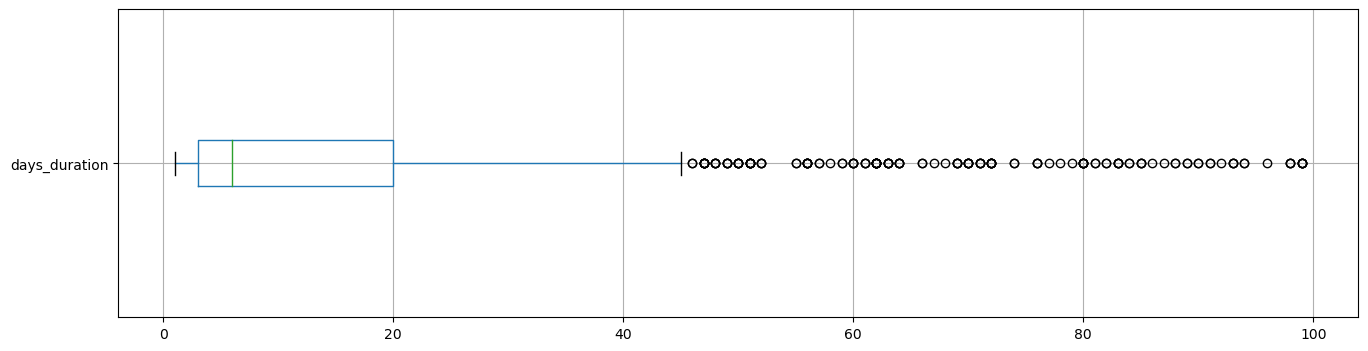

In [43]:
### Bataille de durées de moins de 100 jours
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)].boxplot(column=['days_duration'], vert=False, figsize=(16,4))
plt.show()

In [37]:
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)].days_duration.describe()

count    1401.000000
mean       15.995004
std        21.179622
min         1.000000
25%         3.000000
50%         6.000000
75%        20.000000
max        99.000000
Name: days_duration, dtype: float64

## Regrouper par années

In [44]:
years_count = pd.DataFrame(df_b.groupby('year').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,-1500,1
1,-1456,1
2,-1324,1
3,-1273,1
4,-1249,1
...,...,...
1283,2019,8
1284,2020,15
1285,2021,6
1286,2022,20


In [45]:
years_count.effectif.max()

122

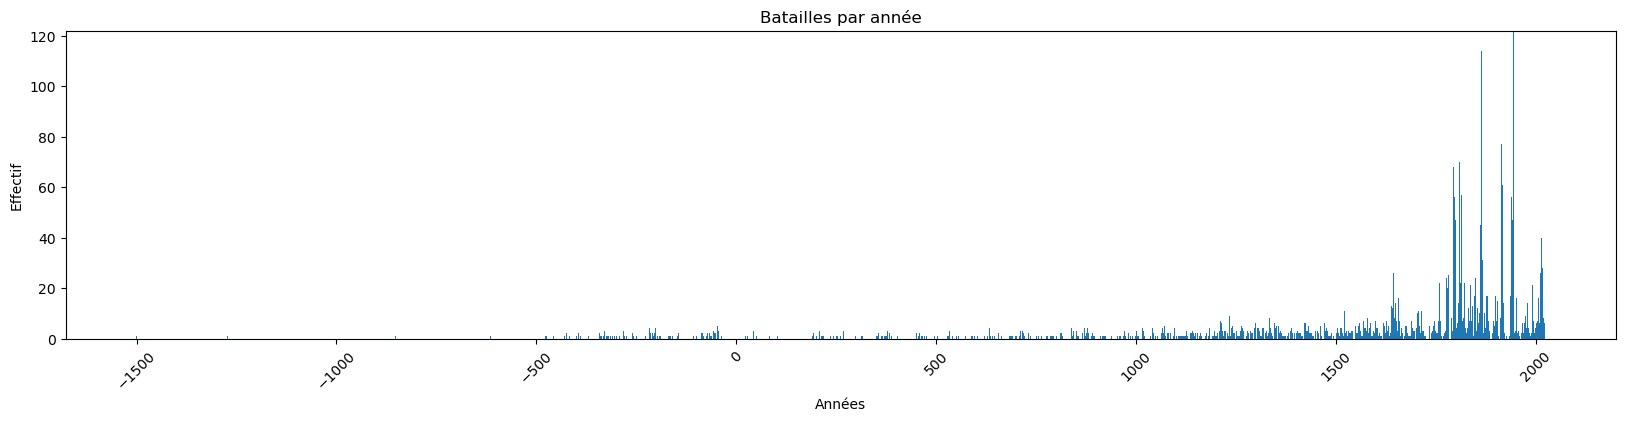

In [52]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']


p1 = plt.bar(objects, eff, width=1)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
plt.ylim(0,max(eff))
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

In [53]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']

years_between = years_count[(years_count.year >1000) & (years_count.year < 1200) ]

print(years_between.head())

     year  effectif
440  1001         3
441  1003         1
442  1004         1
443  1006         1
444  1009         1


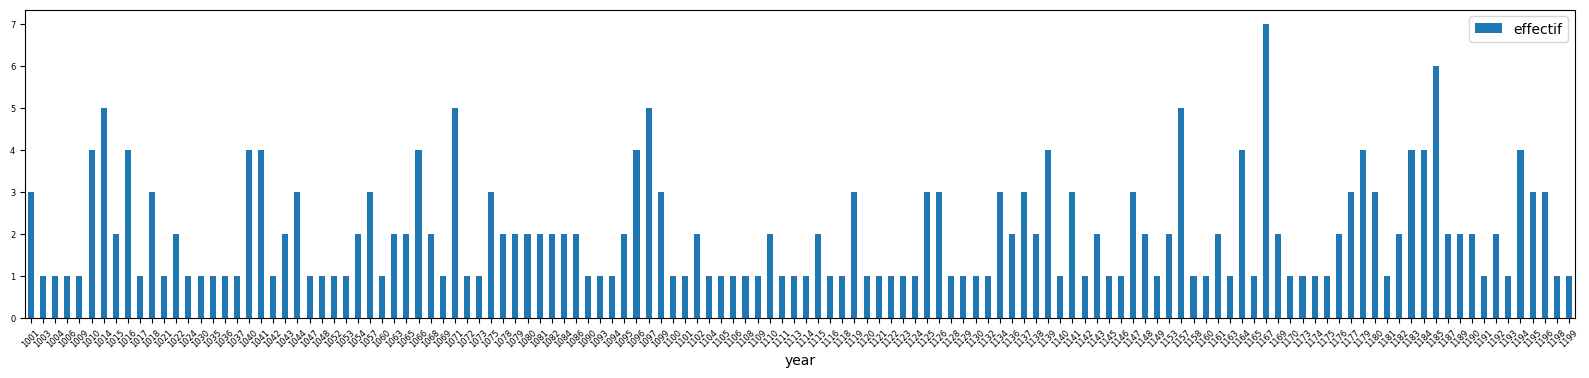

In [57]:
### Attention représentation fautive: il n'y a pas de trous !
# L'axe du temps est donc faussé, il est plus court que qu'il doit être

years_between.plot(kind='bar', x='year', figsize=(20,4), rot=45, fontsize=6)
plt.show()

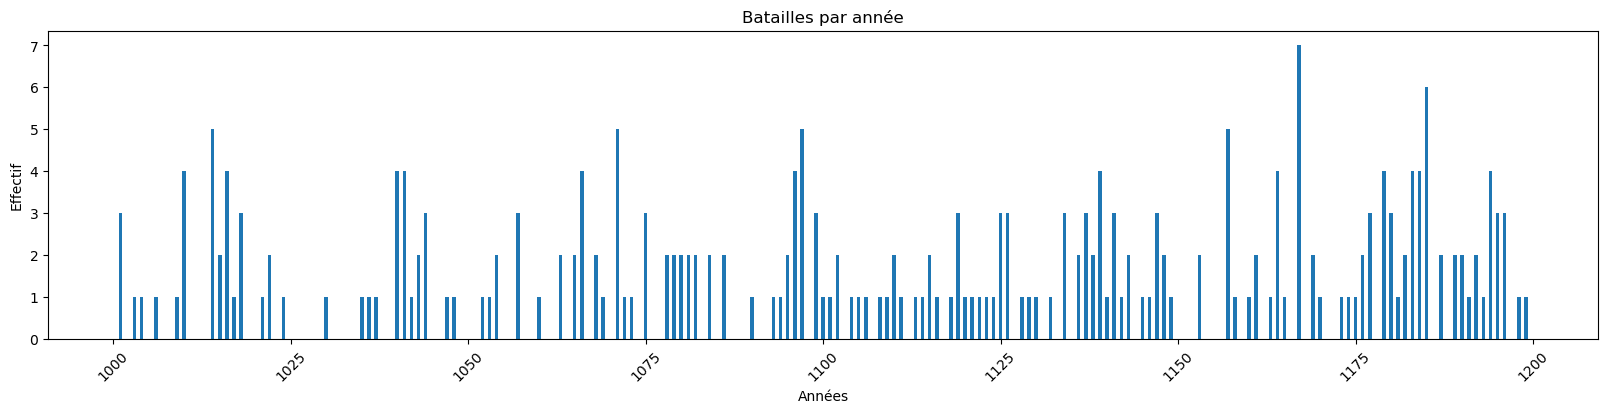

In [58]:
### Représentation correcte

objects = years_between['year']
eff = years_between['effectif']


p1 = plt.bar(objects, eff, width=0.5)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

## Regrouper par périodes de 25 ans

In [59]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_b = df_b[df_b['year'] > 1000].copy(deep=True)

In [60]:
cdf_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
0,http://www.wikidata.org/entity/Q219230,Marco Polo Bridge incident,Point(116.213056 39.849167),1937-07-09T00:00:00Z,1937-07-07T00:00:00Z,1937-07-09T00:00:00Z,1937,3
1,http://www.wikidata.org/entity/Q244980,Siege of Belgrade,Point(20.466666666 44.816666666),1456-01-01T00:00:00Z,1456-07-13T00:00:00Z,1456-07-31T00:00:00Z,1456,19
2,http://www.wikidata.org/entity/Q221891,Second Battle of Artois,Point(2.75 50.5),1915-06-18T00:00:00Z,1915-05-09T00:00:00Z,1915-06-18T00:00:00Z,1915,41
3,http://www.wikidata.org/entity/Q154182,Battle of Berlin,Point(13.376111111 52.518611111),1945-05-02T00:00:00Z,1945-04-16T00:00:00Z,1945-05-02T00:00:00Z,1945,17
4,http://www.wikidata.org/entity/Q371620,First Battle of Benghazi,Point(20.066666666 32.116666666),2011-02-20T00:00:00Z,2011-02-15T00:00:00Z,2011-02-20T00:00:00Z,2011,6


### Codage par période de vingt-cinq ans

In [61]:
l_25 = list(range(1001, 2027, 25))
l_25[:5],l_25[-5:]

([1001, 1026, 1051, 1076, 1101], [1926, 1951, 1976, 2001, 2026])

In [65]:
### Effectuer le codage
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html


cdf_b['periodes'] = pd.cut(cdf_b['year'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_b['periodes'] = cdf_b['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_b.head(3)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
0,http://www.wikidata.org/entity/Q219230,Marco Polo Bridge incident,Point(116.213056 39.849167),1937-07-09T00:00:00Z,1937-07-07T00:00:00Z,1937-07-09T00:00:00Z,1937,3,1926-1950
1,http://www.wikidata.org/entity/Q244980,Siege of Belgrade,Point(20.466666666 44.816666666),1456-01-01T00:00:00Z,1456-07-13T00:00:00Z,1456-07-31T00:00:00Z,1456,19,1451-1475
2,http://www.wikidata.org/entity/Q221891,Second Battle of Artois,Point(2.75 50.5),1915-06-18T00:00:00Z,1915-05-09T00:00:00Z,1915-06-18T00:00:00Z,1915,41,1901-1925


In [63]:
cdf_b[cdf_b.year == 2015][:3]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
1412,http://www.wikidata.org/entity/Q19428973,Al-Hasakah offensive,Point(41.4 36.75),2015-03-17T00:00:00Z,2015-02-21T00:00:00Z,2015-03-17T00:00:00Z,2015,25,2001-2025
1421,http://www.wikidata.org/entity/Q20984822,2015 Fotokol attack,Point(14.230555555 12.3775),2015-02-01T00:00:00Z,2015-02-04T00:00:00Z,2015-02-05T00:00:00Z,2015,2,2001-2025
1434,http://www.wikidata.org/entity/Q19926256,Palmyra Offensive,Point(38.267222222 34.56),2015-05-26T00:00:00Z,2015-05-13T00:00:00Z,2015-05-25T00:00:00Z,2015,13,2001-2025


In [68]:
cdf_b.groupby(by='periodes').size()

periodes
1001-1025     30
1026-1050     20
1051-1075     29
1076-1100     32
1101-1125     28
1126-1150     36
1151-1175     30
1176-1200     51
1201-1225     65
1226-1250     43
1251-1275     58
1276-1300     54
1301-1325     60
1326-1350     62
1351-1375     45
1376-1400     39
1401-1425     68
1426-1450     62
1451-1475     62
1476-1500     38
1501-1525     66
1526-1550     68
1551-1575    106
1576-1600     89
1601-1625     73
1626-1650    206
1651-1675    102
1676-1700     71
1701-1725    116
1726-1750     51
1751-1775    158
1776-1800    593
1801-1825    527
1826-1850    228
1851-1875    608
1876-1900    167
1901-1925    465
1926-1950    580
1951-1975    141
1976-2000    122
2001-2025    329
dtype: int64

In [71]:
### Vérifier que toutes les périodes sont renseignées
# un valeur en plus dans la liste
len(l_25)-1, len(cdf_b.groupby(by='periodes').size())

(41, 41)

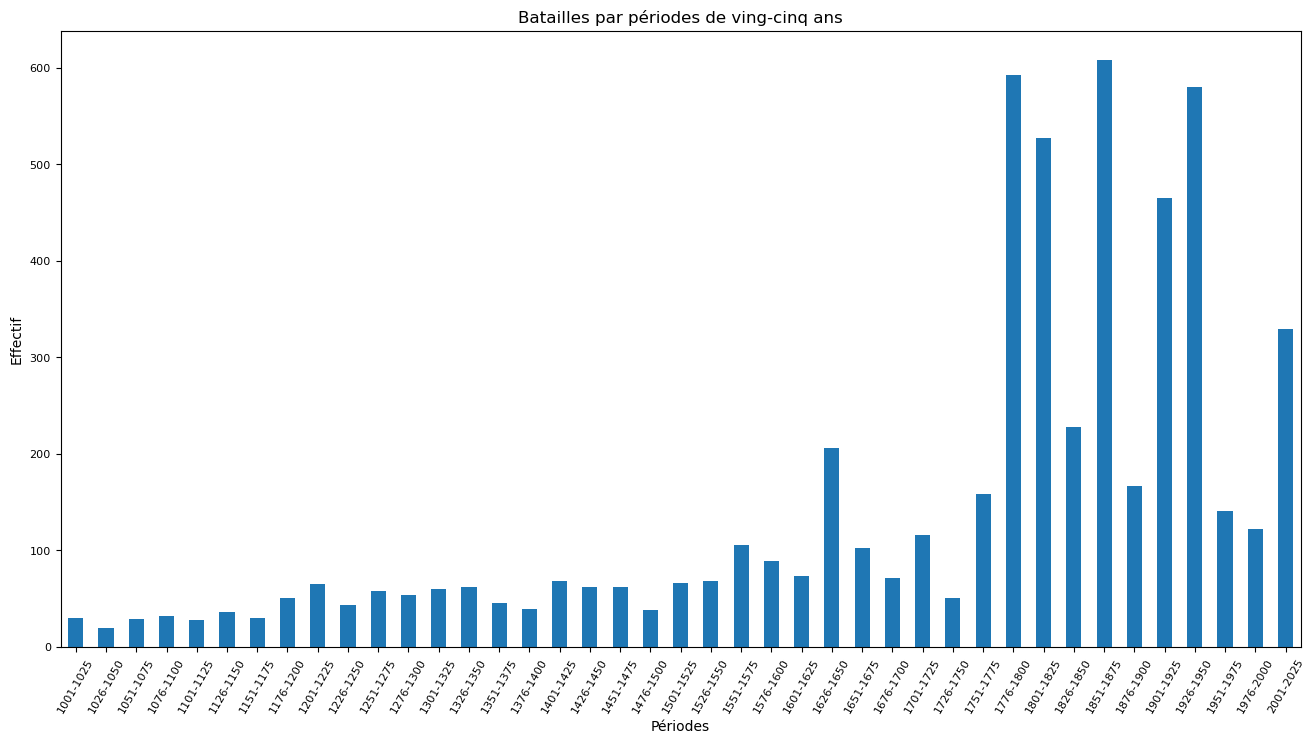

In [72]:
ax = cdf_b.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Batailles par périodes de ving-cinq ans')
plt.show()

### Afficher les durées 

In [73]:
cdf_b.head(3)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
0,http://www.wikidata.org/entity/Q219230,Marco Polo Bridge incident,Point(116.213056 39.849167),1937-07-09T00:00:00Z,1937-07-07T00:00:00Z,1937-07-09T00:00:00Z,1937,3,1926-1950
1,http://www.wikidata.org/entity/Q244980,Siege of Belgrade,Point(20.466666666 44.816666666),1456-01-01T00:00:00Z,1456-07-13T00:00:00Z,1456-07-31T00:00:00Z,1456,19,1451-1475
2,http://www.wikidata.org/entity/Q221891,Second Battle of Artois,Point(2.75 50.5),1915-06-18T00:00:00Z,1915-05-09T00:00:00Z,1915-06-18T00:00:00Z,1915,41,1901-1925


In [74]:
df_cdf_b = pd.DataFrame(cdf_b[['label', 'year', 'days_duration' ]][cdf_b['days_duration'] > 1000])
#df_cdf_b.columns=['lustre', 'femmes']
df_cdf_b.head()

,label,year,days_duration
455,Battle of the Frontiers,1914,1864
464,Battle of Fuentes de Oñoro,1811,1450
1044,Battle of Aleppo,2016,1618
1129,Battle of Anjō,1540,3289
1138,Great Siege of Montevideo,1843,3157


In [75]:
cdf_b[cdf_b.days_duration < 1].head()

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
1250,http://www.wikidata.org/entity/Q125092483,Q125092483,Point(30.035944 61.7085),1614-01-01T00:00:00Z,1614-08-06T00:00:00Z,http://www.wikidata.org/.well-known/genid/5816...,1614,-1,1601-1625
1487,http://www.wikidata.org/entity/Q304655,First Battle of Auburn,Point(-77.7 38.7),1863-10-13T00:00:00Z,,,1863,-1,1851-1875
1488,http://www.wikidata.org/entity/Q233417,Battle of the Assunpink Creek,Point(-74.764166666 40.218055555),1777-01-02T00:00:00Z,,,1777,-1,1776-1800
1489,http://www.wikidata.org/entity/Q324344,Battle of Roliça,Point(-9.18361 39.3136),1808-08-17T00:00:00Z,,,1808,-1,1801-1825
1490,http://www.wikidata.org/entity/Q281089,Battle of Ludford Bridge,Point(-2.718888888 52.36375),1459-10-12T00:00:00Z,,,1459,-1,1451-1475


In [76]:
### Regrouper et compter par batailles sans durée
sans_duration = pd.DataFrame(cdf_b[cdf_b.days_duration < 1].groupby('periodes').size())
sans_duration.columns = ['effectif_sans']
sans_duration.tail()

,effectif_sans
periodes,
1901-1925,219
1926-1950,201
1951-1975,73
1976-2000,66
2001-2025,180


In [77]:
### Regrouper et compter par batailles sans durée
avec_duration = pd.DataFrame(cdf_b[cdf_b.days_duration > 0].groupby('periodes').size())
avec_duration.columns = ['effectif_avec']
avec_duration.tail()

,effectif_avec
periodes,
1901-1925,246
1926-1950,379
1951-1975,68
1976-2000,56
2001-2025,149


In [79]:
### Réunir les tableaux en utilisant l'index
merged = pd.merge(sans_duration, avec_duration, left_index=True, right_index=True)
merged.tail()

,effectif_sans,effectif_avec
periodes,,
1901-1925,219,246
1926-1950,201,379
1951-1975,73,68
1976-2000,66,56
2001-2025,180,149


In [82]:
### Transformer l'index en chaine de caractères (était 'catégorie') afin que le graphique suivente s'affiche
merged.index = merged.index.map(str)
merged.tail()

,effectif_sans,effectif_avec
periodes,,
1901-1925,219,246
1926-1950,201,379
1951-1975,73,68
1976-2000,66,56
2001-2025,180,149


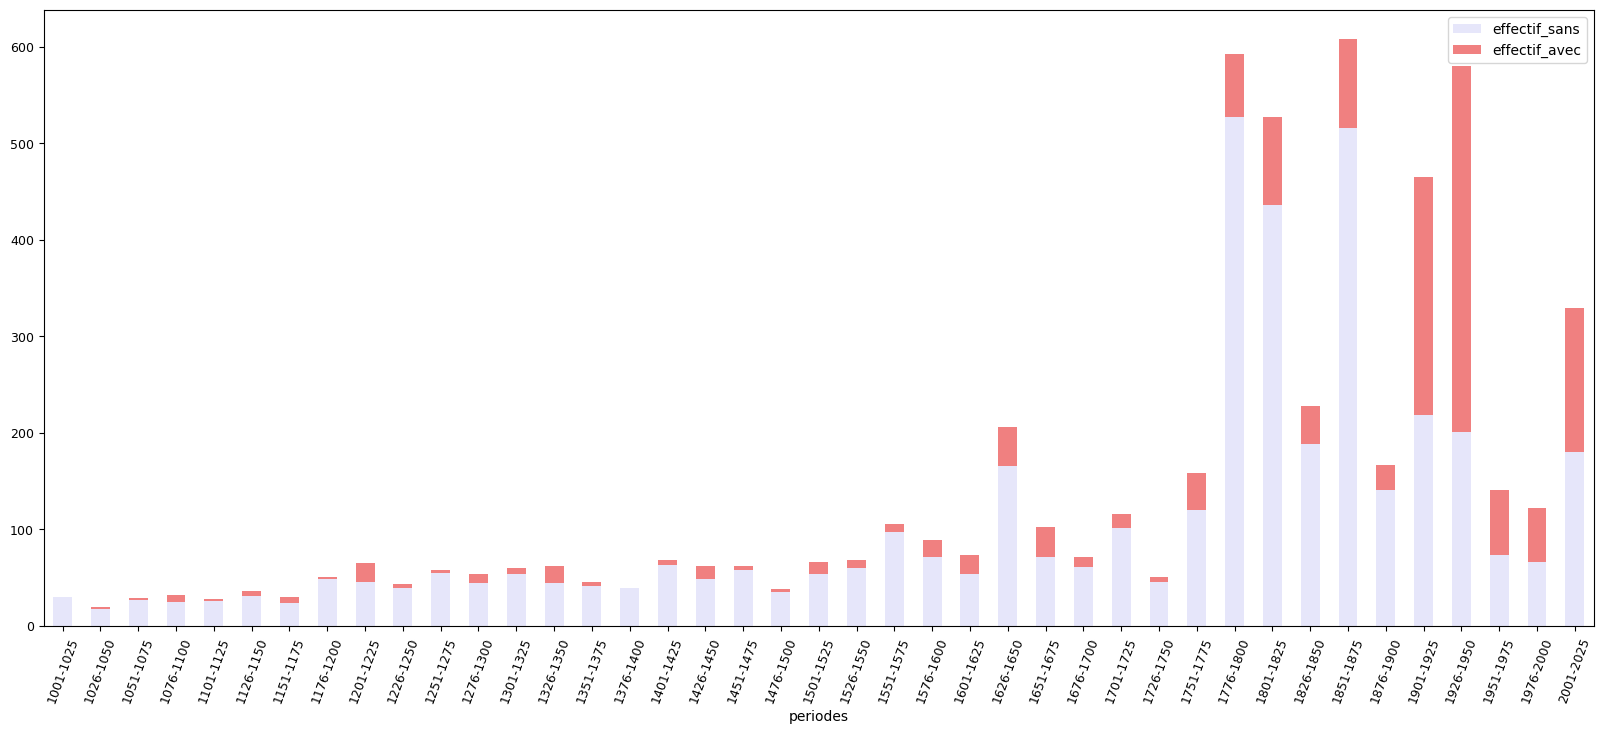

In [83]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8), color=['Lavender', 'LightCoral'])
plt.show()

## Afficher les médianes des durées par période

Nombre de batailles comparé à leur durée

In [87]:
### Médiane
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)]
# https://datascienceparichay.com/article/pandas-groupby-median/
cdf_b[(cdf_b['days_duration'] > 0) & (cdf_b.days_duration < 100)]\
      .groupby(by='periodes')['days_duration'].median()

periodes
1001-1025     NaN
1026-1050     1.5
1051-1075     1.0
1076-1100     4.0
1101-1125     1.0
1126-1150     1.0
1151-1175     2.0
1176-1200     1.0
1201-1225     1.0
1226-1250     7.5
1251-1275     3.0
1276-1300     1.5
1301-1325     2.0
1326-1350     5.0
1351-1375     1.5
1376-1400     NaN
1401-1425    33.0
1426-1450     4.0
1451-1475    10.0
1476-1500    39.0
1501-1525    22.0
1526-1550    20.0
1551-1575    26.0
1576-1600     4.0
1601-1625    46.5
1626-1650    11.0
1651-1675     8.0
1676-1700     7.0
1701-1725    14.0
1726-1750    10.5
1751-1775    10.0
1776-1800     3.0
1801-1825     3.0
1826-1850     3.0
1851-1875     3.0
1876-1900     3.0
1901-1925     8.0
1926-1950     9.0
1951-1975     5.0
1976-2000     5.0
2001-2025     7.0
Name: days_duration, dtype: float64

In [88]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
avec_duration = pd.DataFrame(cdf_b[cdf_b.days_duration > 0].groupby('periodes').size())
avec_duration.columns = ['effectif']
avec_duration.tail()

,effectif
periodes,
1901-1925,246
1926-1950,379
1951-1975,68
1976-2000,56
2001-2025,149


In [89]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
avec_duration_median = pd.DataFrame(cdf_b[(cdf_b['days_duration'] > 0) & (cdf_b.days_duration < 100)].groupby('periodes')['days_duration'].agg('median'))
avec_duration_median.columns = ['median']
avec_duration_median.tail()

,median
periodes,
1901-1925,8.0
1926-1950,9.0
1951-1975,5.0
1976-2000,5.0
2001-2025,7.0


In [90]:
merged_median = pd.merge( avec_duration, avec_duration_median, left_index=True, right_index=True)
merged_median.tail()

,effectif,median
periodes,,
1901-1925,246,8.0
1926-1950,379,9.0
1951-1975,68,5.0
1976-2000,56,5.0
2001-2025,149,7.0


In [91]:
merged_median.index = merged_median.index.map(str)
merged_median.tail()

,effectif,median
periodes,,
1901-1925,246,8.0
1926-1950,379,9.0
1951-1975,68,5.0
1976-2000,56,5.0
2001-2025,149,7.0


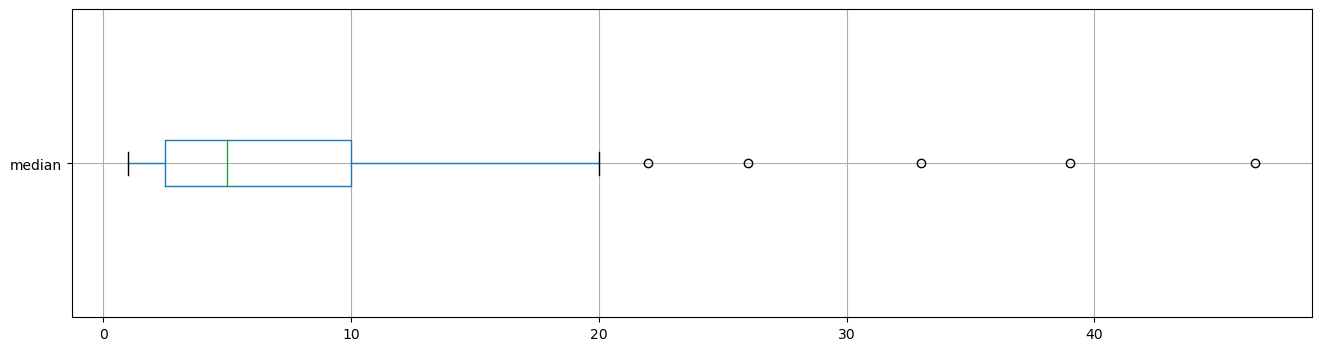

In [92]:
merged_median[merged_median['median'] < 100].boxplot(column=['median'], vert=False, figsize=(16,4))
plt.show()

In [93]:
medians = list(merged_median[merged_median['median'] < 20]['median'].fillna(0))
print(sorted(medians), len(medians))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.5, 8.0, 8.0, 9.0, 10.0, 10.0, 10.5, 11.0, 14.0] 33


In [94]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize

In [95]:
colormap_1 = LinearSegmentedColormap.from_list('colorbar', ['#D8B5FF','#1EAE98'], N=len(medians))
norm = Normalize(vmin=min(medians), vmax=max(medians))
colors = [colormap_1(norm(v)) for v in medians]

In [96]:
colors[:3]

[(0.8242647058823529, 0.7089460784313726, 0.9873774509803922, 1.0),
 (0.8470588235294118, 0.7098039215686275, 1.0, 1.0),
 (0.6875, 0.7037990196078432, 0.9116421568627451, 1.0)]

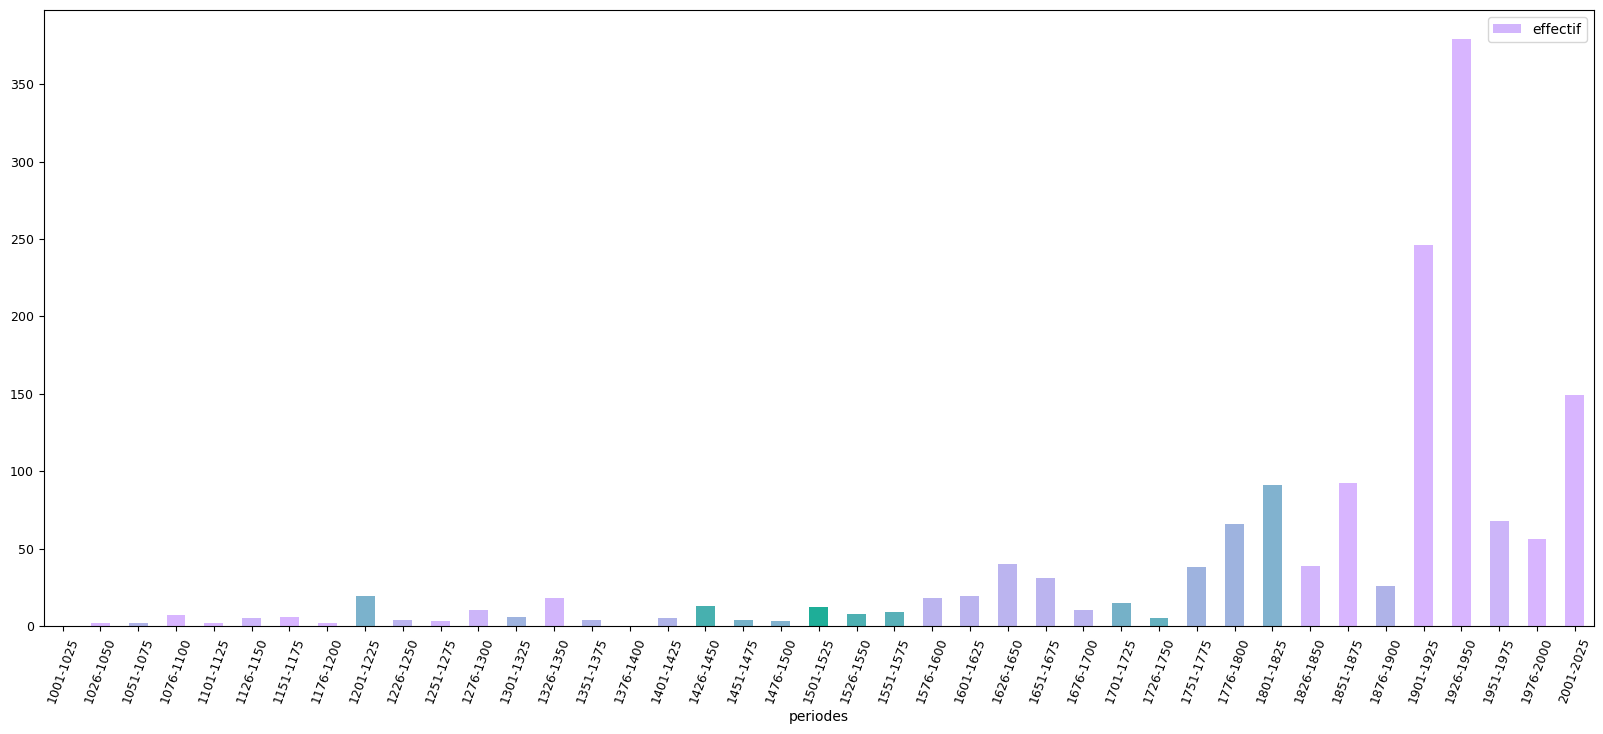

In [97]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
## pour les couleurs
# https://stackoverflow.com/questions/60132409/use-a-third-column-of-values-to-map-a-color-gradient-to-a-plot-of-column-1-and-c
# https://stackoverflow.com/questions/66716402/how-to-and-apply-custom-gradient-colormap-on-a-bar-chart

ax = merged_median.plot.bar(rot=70, y='effectif', fontsize=9, figsize=(20,8), color = colors)
plt.show()

In [98]:
print(medians)

[1.5, 1.0, 4.0, 1.0, 1.0, 2.0, 1.0, 1.0, 7.5, 3.0, 1.5, 2.0, 5.0, 1.5, 4.0, 10.0, 4.0, 11.0, 8.0, 7.0, 14.0, 10.5, 10.0, 3.0, 3.0, 3.0, 3.0, 3.0, 8.0, 9.0, 5.0, 5.0, 7.0]


In [99]:
### Inspecter les données de périodes particulières
cdf_b[(cdf_b['days_duration'] > 0) & (cdf_b.periodes.isin(['1201-1225','1426-1450']))].sort_values(by='year')

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
831,http://www.wikidata.org/entity/Q767844,Siege of Constantinople,Point(28.976018 41.01224),1203-08-08T00:00:00Z,1203-07-17T00:00:00Z,1203-08-01T00:00:00Z,1203,16,1201-1225
879,http://www.wikidata.org/entity/Q767844,Siege of Constantinople,Point(28.9769 41.0167),1203-08-08T00:00:00Z,1203-07-17T00:00:00Z,1203-08-01T00:00:00Z,1203,16,1201-1225
936,http://www.wikidata.org/entity/Q3485813,Siege of Antalya,Point(30.69556 36.90812),1207-03-01T00:00:00Z,1207-03-01T00:00:00Z,1207-03-01T00:00:00Z,1207,1,1201-1225
1355,http://www.wikidata.org/entity/Q941312,massacre at Béziers,Point(3.21899 43.3476),1209-07-29T00:00:00Z,1209-07-29T00:00:00Z,1209-07-29T00:00:00Z,1209,1,1201-1225
425,http://www.wikidata.org/entity/Q587163,Siege of Minerve,Point(2.746388888 43.354166666),1210-07-29T00:00:00Z,1210-06-22T00:00:00Z,1210-07-29T00:00:00Z,1210,38,1201-1225
1006,http://www.wikidata.org/entity/Q4890612,Siege of Al-Dāmūs,Point(-1.2862304 40.0632676),1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210,1,1201-1225
488,http://www.wikidata.org/entity/Q587163,Siege of Minerve,Point(2.747222222 43.354722222),1210-07-29T00:00:00Z,1210-06-22T00:00:00Z,1210-07-29T00:00:00Z,1210,38,1201-1225
496,http://www.wikidata.org/entity/Q587163,Siege of Minerve,Point(2.73528 43.35),1210-07-29T00:00:00Z,1210-06-22T00:00:00Z,1210-07-29T00:00:00Z,1210,38,1201-1225
994,http://www.wikidata.org/entity/Q4890612,Siege of Al-Dāmūs,Point(-1.28333333 40.06666667),1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210,1,1201-1225
721,http://www.wikidata.org/entity/Q2750179,Siege of Castelnòu d'Arri,Point(1.953888888 43.318055555),1211-09-01T00:00:00Z,1211-09-01T00:00:00Z,1211-09-01T00:00:00Z,1211,1,1201-1225
